In [1]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, AIMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

/home/rishukumar/Documents/CampusX/CampusX_Code/LangGraph_CampusX/myenv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

True

In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash"
)

E0000 00:00:1766854408.837084   32984 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [6]:
# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

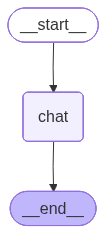

In [7]:
app

In [8]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [9]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='04e28cd5-ebdb-44de-a755-60209caec545')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='c12e1f252635ca277e77ed9cddab39e5')]}

In [10]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [11]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [12]:

# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [13]:
print(final_result["messages"][-1].content)

Imagine you're blindfolded and standing on a mountain. Your goal is to find the absolute lowest point in the valley. You can't see the whole landscape, but you can feel the ground right under your feet.

Here's how you'd do it, and that's exactly what Gradient Descent does:

1.  **Feel the Slope:** You'd feel around with your feet to figure out which direction is *downhill* and which direction is the *steepest downhill*.
2.  **Take a Small Step:** Once you find the steepest downhill direction, you'd take a small step in that direction.
3.  **Repeat:** You'd repeat this process again and again: feel the slope, take a small step downhill.

Eventually, by repeatedly taking small steps in the steepest downhill direction, you'd reach the bottom of the valley.

---

**Translating this to computers:**

*   **The Mountain/Valley:** This is like the "error" or "cost" of your computer model. When the model is bad, the "error" is high (you're high on the mountain). When it's good, the "error" is 